# Example 3

In this notebook we show how to benchmark perfromance of the model over the multiple iterations. We will measure evoluion of the best score over multiple runs. Each run is described in Exapmle 2.

In [1]:
# Necessary imports
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
from pylab import meshgrid
import matplotlib.pyplot as plt
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.optim import optimize_acqf

/opt/anaconda3/envs/hackaton/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we define function used to describe "real" model. This function plays role of pseudoexperiment - in real life it is unknown, we do experiments to measure it in proposed points, and our algorithm aims to find its global minimum. Now we use [benchmark-functions](https://gitlab.com/luca.baronti/python_benchmark_functions) library to pick a function.

In [2]:
import benchmark_functions as bf

target_func = bf.Griewank(n_dimensions=2, zoom = 2, opposite = True)

def func(x):
    """Auxilary funciton to apply target function to tensor.
    We transform axis so that ranges of all axis are [0, 1]
        
    Inputs:
        x -  tensor of input data. Size of the last dimension mattch dimensionality of data
        func - function of `dim`
    """
    y = []
    bounds = np.array(target_func.suggested_bounds())
    for xi in x.view(np.prod(x.shape[:-1]),x.shape[-1]).tolist():
        _xi = np.array(xi)*(bounds[1]-bounds[0])+bounds[0]
        y.append(target_func(_xi))
    y = torch.FloatTensor(y).reshape(x.shape[:-1]+torch.Size([1]))
    return y    

In [3]:
def next_data_point(train_X, func):
    """This function creates runs botorch optimisaiton over the given dataset and returns the next point.
    
    Inputs:
        train_X - tensor of the shape (size, dim)
        func - function taking data point(s) and returning tensor of values
    Output:
        data_point - tensor of the shape (1, dim)
    """
    
    # Getting values of target function in train points
    train_Y = func(train_X) 
    # Defining the model
    gp = SingleTaskGP(train_X, train_Y)
    # Defining cost function
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    # Set model's parameters to those that maximize likelihood.
    fit_gpytorch_model(mll)
    # Defining acquisition function
    ei = ExpectedImprovement(gp, best_f = train_Y.max())
    # Domain of the target function.
    data_dim =  train_X.shape[-1]
    bounds = torch.stack([torch.zeros(data_dim), torch.ones(data_dim)])
    # Botorch suggestion
    candidate, acq_value = optimize_acqf(
        ei, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    return candidate

In [4]:
def get_n_points(data_dim, n, func, next_data_point, train_X = None):
    """A function returning results of iterative pseudo-experiments.
    If not specified, a sequence starts with 2 random points.
    
    Inputs:
        data_dim - dimensionality of data
        n - required number of points
        func - target function
        next_data_point - function returning the next candidate
        train_X - tensor of shape (size x dim). Size is a size of starting dataset, 
            dim is dimensionality of a problem.
    """
    n_extra = n

    if train_X is None:
        n_start = 2
        train_X = torch.rand(n_start, 2)

    for i in range(1, 1+n_extra):
        candidate = next_data_point(train_X, func)
        train_X = torch.cat((train_X,candidate), 0)
    
    return train_X

Running 100 pseudo experiments now:

In [5]:
data_dim = 2
n_points = 10
result = []
for i in range(100):
    if i == 0:
        result = get_n_points(data_dim, n_points, func, next_data_point)[None]
    else:
        result = torch.cat((result,get_n_points(data_dim, n_points, func, next_data_point)[None]))

/opt/anaconda3/envs/hackaton/lib/python3.8/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/anaconda3/envs/hackaton/lib/python3.8/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/anaconda3/envs/hackaton/lib/python3.8/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize

/opt/anaconda3/envs/hackaton/lib/python3.8/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/anaconda3/envs/hackaton/lib/python3.8/site-packages/botorch/optim/optimize.py:287: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/opt/anaconda3/envs/hackaton/lib/python3.8/site-packages/botorch/optim/optimize.py:298: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Lets plot evolution of the best score.

Text(0, 0.5, 'Objective')

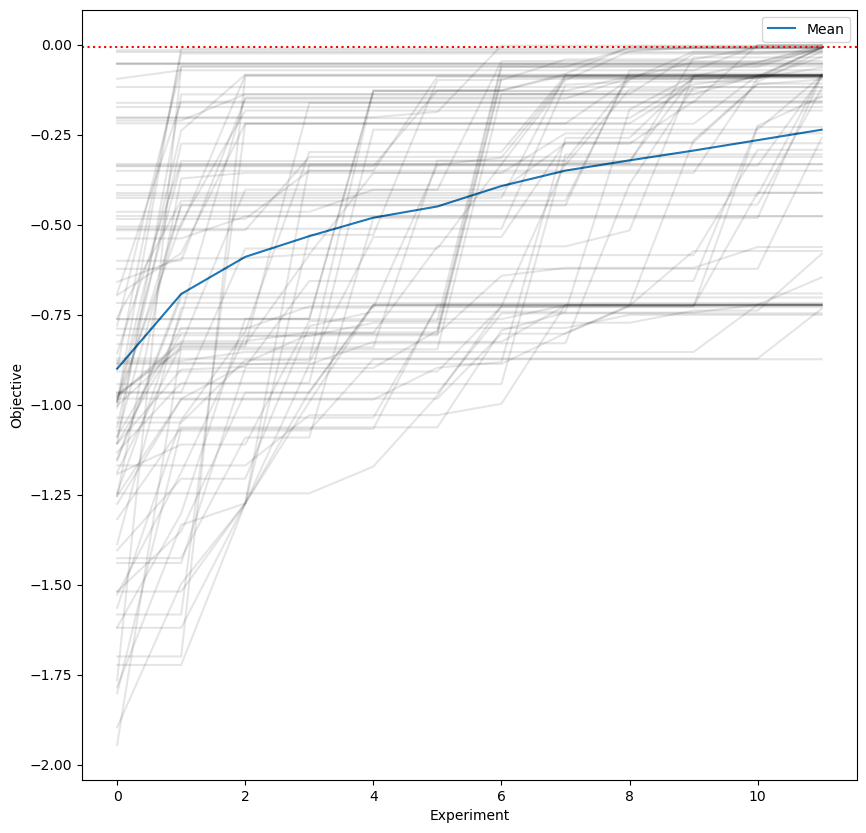

In [7]:
y_result = func(result).squeeze().tolist()
best_results_all = []

for results in y_result:
    best_results = [results[0]]
    for r in results[1:]:
        if r >= best_results[-1]:
            best_results.append(r)
        else:
            best_results.append(best_results[-1])
    best_results_all.append(best_results)
best_results_all_mean = np.array(best_results_all).T.mean(axis = 1)

f = plt.figure(figsize = (10, 10))
plt.plot(best_results_all_mean, label = "Mean")
for br in best_results_all:
    plt.plot(br, color = "black", alpha = .1)
plt.legend()
plt.axhline(target_func.maximum().score, color = "red", ls = ":")
plt.xlabel("Experiment")
plt.ylabel("Objective")